> Note: All code used in this notebook is contained in the [notebooks/beaconrunner2049](https://github.com/barnabemonnot/beaconrunner/tree/master/notebooks/beaconrunner2049) folder of the Beacon runner repo, and does not use current eth2.0 specs. Most of the content here remains applicable.

## TL;DR

- We improve upon our first [_Beacon Runner_](br.html), an economics-focused simulation environment for eth2.
- We introduce network-level events and simulate a partition. Stake from inactive validators is leaked until active validators dominate on their side of the partition, so finalisation can resume.
- We make a short detour to introduce aggregation of attestations.

---

In this notebook, we extend the [_Beacon Runner_](br.html) to create network-level events. This is a second step towards an abstracted (but realistic) simulation environment to study economic properties of validation of eth2. We will make use of our p2p network abstraction to simulate a network partition, where for some reason (an adversary, [a Georgian granny](https://www.theguardian.com/world/2011/apr/06/georgian-woman-cuts-web-access), World War III) the network is split in two with both sides unable to communicate with each other.

To recap' what happened in our [first notebook](br.html), we wrapped the [current eth2 specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/beacon-chain.md) in a [cadCAD](https://github.com/BlockScience/cadCAD) environment. This wrap augmented the dynamics of chain updates (forming and adding a new block) with validator _policies_, which inform the state updates. We assumed zero network latency, i.e., all validators aware of all events as they happen, and sharing the same view of the chain. In practice, this assumption does not hold. We usually assume a _partially synchronous_ model, where all validators are _eventually_ informed of any event, with no bound on how long this may take (but a finite time in any case).

Under a partially synchronous model, validators may not share the same view of the chain, since they may not be aware that a new block was created when they have not yet received it from the underlying p2p network. In the worst-case, an adversary manipulating the network can successfully game the view of other validators. If they are skilled enough, they could even [pretend that their manipulation is not malicious and is the result of unfortunate network delays](https://ethresear.ch/t/non-attributable-censorship-attack-on-fraud-proof-based-layer2-protocols/6492). How can we create policies that are _robust_ to network uncertainty and strategic interactions?

We will develop these questions throughout, getting insight from our models and simulations.

## Setting up

First, we need to load the beacon chain specs, as defined by the [canonical eth2 repo](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/beacon-chain.md). This time, we're using the new `eth2spec` Python package that you can pull directly with `pip` or `pipenv`. We've also built our own version of the specs using the procedure detailed [here](https://github.com/ethereum/eth2.0-specs/tree/dev/tests/core/pyspec#dev-install). It's so simple!

Dealing with the specs constants, like the number of slots per epoch or the base reward factors is also much easier now. We define two different config files, `fast.yaml` and `medium.yaml`. `fast` has a value of `SLOTS_PER_EPOCH` set to 4. We don't have time to waste! `medium` sets it to 16 and changes a few other things -- we'll tell you more about it when we get there.

So we import our own custom-built `specs`, prepare the `fast` config file and reload the specs to apply this configuration.

In [1]:
%%capture
import specs
import importlib
from eth2spec.config.config_util import prepare_config

prepare_config(".", "fast.yaml")
importlib.reload(specs)

We import a few libraries we will need for our simulations: `network` contains the network implementation we describe below, while `brlib` contains our validator policies.

We also import cadCAD's libraries and `pandas` to work with the simulations output.

In [2]:
import network as nt
import brlib

import copy

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from cadCAD import configs

import pandas as pd

## Network model

We use a simple p2p network abstraction. Nodes are identified by an index and belong to various _information sets_. Node $a$ produces an event (a new attestation, a new block) at $t=0$. Let $I(a,t)$ denote the set of nodes who know about events produced by $a$ after duration $t$.

- At $t=0$, $I(a,0) = \{ a \}$, meaning only node $a$ knows about the event at $t=0$.
- At $t=1$, we look for all the information sets that $a$ belongs to, denoted by $I_a$. All nodes belonging to sets in $I_a$ learn about this event. We call $I(a,1)$ the set of nodes who know about the event at $t=1$. They are the nodes who "heard it from $a$", plus $a$ itself.
- At $t=2$, all nodes belonging to sets where at least one node in $I(a,1)$ belongs to also learn about the event. These nodes are $I(a,2)$, the nodes who "heard it from someone who heard it from $a$", plus the nodes who heard it from $a$ and $a$ itself.
- etc etc.

Progressively, more and more nodes learn about the event as it is propagated over the p2p network. The implementation is available in the `network.py` file. Let's take a simple example.

In [3]:
set_a = nt.NetworkSet(validators=list([0,1]))
set_b = nt.NetworkSet(validators=list([1,2]))
set_c = nt.NetworkSet(validators=list([2,3]))
net = nt.Network(sets=[set_a, set_b, set_c])

Here we have four validators, 0, 1, 2 and 3 connected in a chain. 0 is connected to 1, who is connected to 2, who is connected to 3. Our information sets are stored in the `network.sets` array with the following indices:

```
index: [validators]
-------------------
0: [0,1]
1: [1,2]
2: [2,3]
```


Same as we did in the [first notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner/br.html), we now create a dummy genesis state with four validators who each deposit 32 ETH in the contract -- the minimum to start validating.

In [4]:
genesis_state = brlib.get_genesis_state(4)
print(genesis_state.slot)
brlib.process_genesis_block(genesis_state)
print(genesis_state.slot)
specs.process_slots(state=genesis_state, slot=1) # We are feeding slot 1, because process_slot() assumes you have moved to slot s, but state is still that of slot s-1.
print(genesis_state.slot)

0
0
1


In the next code chunk, validator 3 disseminates an `Attestation` object, which is kept in the `items` attributes of the network. 

_Note:_ We use [brlib.py](https://github.com/barnabemonnot/beaconrunner/tree/master/notebooks/beaconrunner2049/brlib.py) -- the Beacon Runner library of validator behaviours -- to create this attestation object. Unlike the first notebook, we won’t be going over the code governing validator policies, but if you’re curious to see how it works, check  it out [here](https://github.com/barnabemonnot/beaconrunner/tree/master/notebooks/beaconrunner2049/brlib.py).

In [5]:
attestation = brlib.honest_attest(genesis_state, 3)
nt.disseminate_attestation(net, 3, attestation)

print("there is", len(net.attestations), "attestations in network")
print("validator sets who know about this attestation:", [d for d in net.attestations[0].info_sets])

there is 1 attestations in network
validator sets who know about this attestation: [2]


As you can see from the `print` statement above, at this stage only the validator set at index 2 knows about the item, i.e., $I(3,1) = \{ 3, 2 \}$.

We call `update_network` to diffuse items in the network by one step. Since validator 2 is in $I(3, 1)$, and validator 1 shares an information set with validator 2, then we expect validator 1 to know about the attestation at $t=2$ (which means $I(3,2) = \{ 3, 2, 1 \}$).

In [6]:
nt.update_network(net)

print("validator sets who know about this attestation:", [d for d in net.attestations[0].info_sets])

validator sets who know about this attestation: [2, 1]


As expected, we now see that validator sets 2 and 1 know about the event.

Since validator 0 shares an information set with validator 1, if we call `update_network` again, we should see that all sets have learned about the event.

In [7]:
nt.update_network(net)

print("validator sets who know about this attestation:", [d for d in net.attestations[0].info_sets])

validator sets who know about this attestation: [2, 1, 0]


Finally, to see things from the perspective of an individual validator, we can use `knowledge_set(network, validator_index)`.

In [8]:
nt.knowledge_set(net, 2)

{'attestations': [(0,
   NetworkAttestation(Container)
       item: Attestation = Attestation(Container)
                               aggregation_bits: SpecialBitlistView = Bitlist[2048](1 bits: 1)
                               data: AttestationData = AttestationData(Container)
                                                           slot: Slot = 0
                                                           index: CommitteeIndex = 0
                                                           beacon_block_root: Root = 0x67f40279b1f01e07a463d4c35e388c10c66ad19cc8404df69d299cb76bfbad0f
                                                           source: Checkpoint = Checkpoint(Container)
                                                                                    epoch: Epoch = 0
                                                                                    root: Root = 0x0000000000000000000000000000000000000000000000000000000000000000
                                        

`knowledge_set` returns a dictionary. In this notebook, we only consider attestations on the network, but in the next, we'll add blocks on there too. Each value in the dictionary is an array of pairs, each pair giving the item and the index of the item in the network queue.

## Modelling a network partition

In a network partition, the network is split in two (or more) components, which are unable to communicate with each other. We can represent it simply with our network class by defining two information sets that do not share any member in common. In particular, to represent the example given in [_Incentives in Ethereum's hybrid Casper protocol_](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nem.2098) by Buterin, Reijsbergen, Leonardos and Piliouras (Figure 6), we assume the first partition contains 60% of the validators, while the remaining 40% are in the second partition.

Our simulation will investigate how finalisation resumes after inactive validators lose their stake to protocol penalties. This time, we will have 100 validators in our network. Since we have more validators, let's go ahead and set `SLOTS_PER_EPOCH` to 16, giving them more room to breathe (note that current specs set `SLOTS_PER_EPOCH` to 32). We'll also increase the penalty from the chain not finalising anymore, so that we can speed up the interesting things in the simulation.

In [9]:
%%capture

prepare_config(".", "medium.yaml")
importlib.reload(specs)
importlib.reload(nt)
importlib.reload(brlib)

Neither partition sees what is going on with the other partition, so we create two beacon states that will evolve in parallel. We associate a beacon state with each network information set. Both states start out in the same initial condition, with 100 registered validators, although, as we will see, only 60 will be active in consensus formation in the first partition, compared to 40 in the second. 

In [10]:
genesis_state = brlib.get_genesis_state(100)
brlib.process_genesis_block(genesis_state)
specs.process_slots(genesis_state, 1)
genesis_state_2 = copy.deepcopy(genesis_state)

set_a = nt.NetworkSet(validators=list(range(0,60)), beacon_state=genesis_state)
set_b = nt.NetworkSet(validators=list(range(60,100)), beacon_state=genesis_state_2)
network = nt.Network(sets=list([set_a, set_b]))

Why are network partitions an issue? Attestations produced by validators in one partition cannot make it to validators in the other. At the start, all validators are assumed to have equal stake (the 32 ETH needed to become a validator), so there is no way for either partition to finalise checkpoints since neither has 2/3rds of the total stake (respectively, they have 60 and 40% of the total stake).

The partition pretty much splits the chain into two branches. We can think of validators as having two _accounts_: one on their side of the partition (_the branch they can keep up with_), and one on the other side (_the branch they can't see_).

The only way for finalisation to resume is for inactive validators on either side to start losing their stake -- this has the effect of  progressively increasing the stake of active validators (as a percentage of the total stake). At some point, active validators will have over 2/3rds of the total stake.

Validators in partition 0 do not see any activity from validators in partition 1, so the branch run by partition 0 slowly penalises validators by emptying their accounts and giving more relative weight to the active validators in partition 0.

The penalties come in different flavours:

- Validators who are not seen producing attestations lose their base reward three times over (2 times for failing to vote on checkpoints, and 1 time for failing to vote on the current head of the chain).
- In addition, when the chain has not finalised blocks for over `MIN_EPOCHS_TO_INACTIVITY_PENALTY` epochs, an additional penalty kicks in to nullify the gains of honest (and timely) validators and add a penalty proportional to the number of epochs since the last finalised block. Gulp!

The second penalty might seem overly strict. But a chain that is not finalising is no good to anyone! The idea is to make it highly unprofitable to keep validating on a chain where some partition or malicious set of validators prevents finalisation.

When the issue is a "simple" partition, as we'll see, the mechanism leaks enough cash from the inactive validators that finalisation resumes after some time, so waiting it out works. But in the case of a malicious attack, where a set of validators may be censoring another set, finalisation can be durably prevented. Compared to having no reward from honestly validating, the cost of coordinating off-chain to fork away malicious validators doesn't seem so bad now.

### Simulation time!

We have quite a few new building blocks to our simulation, with most of the code is abstracted away in our [brlib.py](https://github.com/barnabemonnot/beaconrunner/tree/master/notebooks/beaconrunner2049/brlib.py) file. Without reading that code though, you should be able to get how the simulation will be built from the way we organise our `block_attestation_psub` array (if you are not sure what this means, take a look at [the first notebook!](br.html)).

In [11]:
%%capture

initial_conditions = {
    'network': network
}

block_attestation_psub = [
    # Step 1+2
    {
        'policies': {
            'action': brlib.attest_policy
        },
        'variables': {
            'network': brlib.disseminate_attestations
        }
    },
    # Step 3+4
    {
        'policies': {
            'action': brlib.propose_policy
        },
        'variables': {
            'network': brlib.disseminate_blocks
        }
    }
]

simulation_parameters = {
    'T': range(300),
    'N': 1,
    'M': {}
}

experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = block_attestation_psub,
    sim_configs = simulation_parameters
)

exec_mode = ExecutionMode() #
exec_context = ExecutionContext() # how to run simulation (single vs. multi threaded, etc.)
simulation = Executor(exec_context=exec_context, configs=configs)
# The `execute()` method returns a tuple; its first elements contains the raw results
raw_result, tensor, sessions = simulation.execute() 
df = pd.DataFrame(raw_result)

# # # Old cadCad way
# # # config = Configuration(initial_state=initial_conditions,
# # #                        partial_state_update_blocks=block_attestation_psub,
# # #                        sim_config=simulation_parameters
# # #                       )

# # # exec_mode = ExecutionMode()
# # # exec_context = ExecutionContext(exec_mode.single_proc)
# # # executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
# # # raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
# # # df = pd.DataFrame(raw_result)

Our simulation has one _state variable_, declared in `initial_conditions`, our `network` object. We run the simulation for 300 steps (= 300 slots). Each step can be broken down in the following substeps:

1. **(Policy):** Validators at state $\omega[s]$ produce attestations for slot $s-1$.
2. **(State update):** Attestations are sent "over-the-wire" and propagate in the network.
3. **(Policy):** Validators who are designated to produce a block for slot $s$ collect attestations they have heard about and build the block.
4. **(State update):** The produced blocks are disseminated and the state is moved to $\omega[s+1]$.

Note that our partition introduces a few difficulties:

- Sometimes, a validator from partition 0 is designated to produce a block for the beacon chain growing in partition 1. In this case no block will be produced in partition 1, since the proposer is either unaware that they were chosen to produce a block or unable to communicate that block to other validators in partition 1.
- Under our model, we assume perfect information except for the partition, i.e., all validators in one partition are always in sync (no latency within partitions). This allows us to optimise by purging the attestations included in blocks from the `network.items` list. If we did not have perfect latency, we would want to keep these attestations around, so that the validator whose turn it is to produce a block in a partition, and who may be unaware of all the blocks created in that same partition, can include attestations that, from their perspective, have not yet been included.

In the background, we have also optimised the storage of attestations with _aggregates_. If the chain works as expected, validators certainly won't get too creative with what they are attesting, and we should expect a whole lot of attestations to look like each other. Why bother keeping track of a thousand times the same object? Aggregates allow us to securely batch these attestations.

Since this topic is fairly central to the larger eth2 construction, let's dive in for a moment.

### Aggregates

If you remember how we built attestations in the [initial Beacon Runner](br.html), we had an `aggregation_bits` attribute in `Attestation` instances. In the previous notebook, we set all bits of the `aggregation_bits` to 0, except for the one bit corresponding to the validator's index in its committee, which we set to 1.

If however, in the ideal case, we expect all validators from the same committee to cast the exact same vote (same source, target and head), why bother collating all these votes as single `Attestation`s?

Instead, we set the bits of the `aggregation_bits` attribute to represent which validators from the committee have cast this exact attestation.

```python
a = Attestation(AttestationData(source, target, head, committee, slot))

# Possible values
a.aggregation_bits = [0, 1] # val. 1 cast attestation a
a.aggregation_bits = [1, 0] # val. 0 cast attestation a
a.aggregation_bits = [1, 1] # vals. 0 and 1 cast attestation a
```

In [eth2's specifications](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/validator.md#attestation-aggregation), each slot, some validators are randomly chosen as aggregators. Their job is to collect a bunch of attestations from diverse validators and package them in unique attestations, with `aggregation_bits` fields set to denote which validators have attested to a particular vote.

In the best case, if all validators of a committee have attested to the same vote, an aggregator will take in their big pile of attestations and output a single one with all bits set to 1. _How can they do that? Why wouldn't they set the bits to anything they want?_ This is the magic of BLS signatures, and the particular case of BLS12-381, an especially friendly elliptic curve that allows us to aggregate signatures securely.

One caveat here is that while signatures are aggregatable, aggregates themselves are not! This means that we couldn't reduce further two aggregates of the same attestation with the following bits: `[0, 1, 1]` and `[1, 1, 0]`. In both aggregates, the second bit is set to 1, meaning that both aggregates have seen the attestation produced by the second validator. Aren't we double-counting then?

We are not! The beacon chain is quite permissive and the second validator would just see their vote included twice: once in the aggregate with bits `[0, 1, 1]`, and once in the aggregate with bits `[1, 1, 0]`. Validators are rewarded for their timeliness, or how fast their attestations are included in the chain. In case a validator's vote is included twice or more, the reward measures how fast their first inclusion was made and only counts that vote. Good guy beacon state!

In our simulation, we follow more or less the same pattern but we do not model the behaviour of aggregators (yet!) Validators produce attestations on their own, setting the aggregate bit to 1 for themselves only. Once the block producer has collected all the attestations that were not included in their version of the chain (remember that we have two partitions!), they aggregate them as much as possible. This is done with the following two pieces of code:

```python
def build_aggregate(state, attestations):
    # All attestations are from the same slot, committee index and vote for
    # same source, target and beacon block.
    if len(attestations) == 0:
        return []

    aggregation_bits = Bitlist[specs.MAX_VALIDATORS_PER_COMMITTEE](*([0] * len(attestations[0].aggregation_bits)))
    for attestation in attestations:
        validator_index_in_committee = attestation.aggregation_bits.index(1)
        aggregation_bits[validator_index_in_committee] = True

    return specs.Attestation(
        aggregation_bits=aggregation_bits,
        data=attestations[0].data
    )

def aggregate_attestations(state, attestations):
    # Take in a set of attestations
    # Output aggregated attestations
    hashes = set([hash_tree_root(att.data) for att in attestations])
    return [build_aggregate(
        state,
        [att for att in attestations if att_hash == hash_tree_root(att.data)]
    ) for att_hash in hashes]
```

The first function, given a set of attestations vouching for the same source, target, head and from the same slot and committee, returns an aggregate attestation with the correct bits set to 1. The second function takes in a set of diverse attestations and groups identical attestations together.

In [12]:
df.iloc[500]['network']

Network(Container)
    sets: List[NetworkSet, 1099511627776] = List[NetworkSet, 1099511627776]<<len=2>>(
                                              NetworkSet(Container)
                                                  validators: List[ValidatorIndex, 1099511627776] = List[ValidatorIndex, 1099511627776]<<len=60>>(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)
                                                  beacon_state: BeaconState = BeaconState(Container)
                                                                                  genesis_time: uint64 = 1578182400
                                                                                  genesis_validators_root: Root = 0x28cab9e03247a689f80750c9e36efd6017819dcce4b45879b0eee46f9e2b6e70
                                                     

### Show me the (leaking) money!

OK, so validators in both partitions are working hard on their own version of the beacon chain, but nothing is finalising. This is because part of the stake is inactive, that is, the validators stuck on the other side cannot attest to anything.

In order to finalise, we need at least 2/3rds of the stake attesting, meaning that active validators should have at least twice as much stake as inactive ones.

Another way of saying this is the following: If we define the _activity ratio_ as the stake of active validators divided by the stake of inactive validators, then this ratio must be at least 2 in order for checkpoints to start finalising.

At the beginning of our simulation, the first partition has an activity ratio of 60/40 = 3/2, while the second partition is at 40/60 = 2/3. Neither is quite at 2 yet! But as time goes by, inactive validators start losing stake to the protocol penalties. Let's see how much.

In [13]:
# Average effective stake of active validators in the first partition
df['active_stake_branch_0'] = df.network.apply(
    lambda network: sum(
        [network.sets[0].beacon_state.validators[validator_index].effective_balance
         for validator_index in network.sets[0].validators]
    ) / 60
)

# Average effective stake of inactive validators in the first partition
df['inactive_stake_branch_0'] = df.network.apply(
    lambda network: sum(
        [network.sets[0].beacon_state.validators[validator_index].effective_balance
         for validator_index in network.sets[1].validators]
    ) / 40
)

# Activity ratio of validators in the first partition
df['activity_ratio_0'] = df['active_stake_branch_0'] * 60 / df['inactive_stake_branch_0'] / 40

# Average effective stake of active validators in the second partition
df['active_stake_branch_1'] = df.network.apply(
    lambda network: sum(
        [network.sets[1].beacon_state.validators[validator_index].effective_balance
         for validator_index in network.sets[1].validators]
    ) / 40
)

# Average effective stake of inactive validators in the second partition
df['inactive_stake_branch_1'] = df.network.apply(
    lambda network: sum(
        [network.sets[1].beacon_state.validators[validator_index].effective_balance
         for validator_index in network.sets[0].validators]
    ) / 60
)

# Activity ratio of validators in the second partition
df['activity_ratio_1'] = df['active_stake_branch_1'] * 40 / df['inactive_stake_branch_1'] / 60

In [14]:
%matplotlib inline

First, let's plot the average stake of active and inactive validators in partition 0.

<AxesSubplot:xlabel='timestep'>

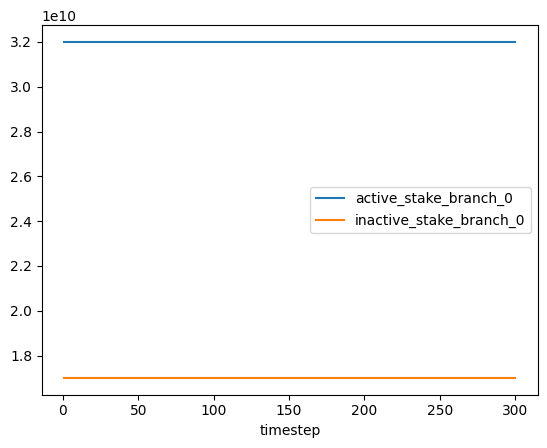

In [15]:
df[df.substep == 1].plot('timestep', ['active_stake_branch_0', 'inactive_stake_branch_0'])

As expected, active validators maintain their effective balance at 32 ETH, while inactive validators quickly feel the wrath of eth2 (in fact, feeling it much quicker than expected since we turned up the `INACTIVITY_PENALTY_QUOTIENT` constant quite a bit). How do our activity ratios compare?

<AxesSubplot:xlabel='timestep'>

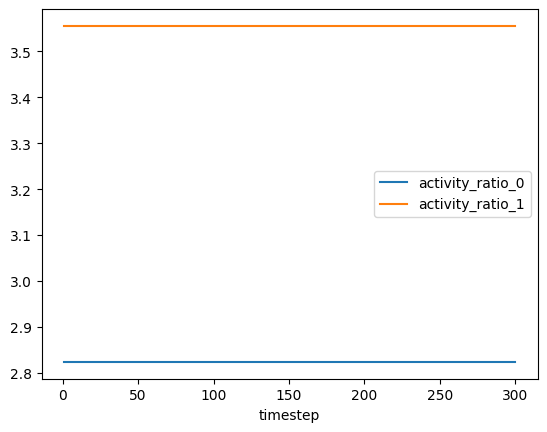

In [16]:
df[df.substep == 1].plot('timestep', ['activity_ratio_0', 'activity_ratio_1'])

Unsurprisingly, partition 0 is the quickest to reach an activity ratio of 2 and so resumes finalisation much earlier than partition 1. Let's dive into what happens as the chains start finalising again. We'll grab a few more outputs from our simulations first.

In [17]:
df['slot'] = df.network.apply(
    lambda network: network.sets[0].beacon_state.slot
)
df['epoch'] = df.network.apply(
    lambda network: specs.get_current_epoch(network.sets[0].beacon_state)
)
df["finalized_epoch"] = df.network.apply(
    lambda nt: nt.sets[0].beacon_state.finalized_checkpoint.epoch
)
df['just_bits'] = df.network.apply(
    lambda network: network.sets[0].beacon_state.justification_bits
)
df['prev_justified_cp'] = df.network.apply(
    lambda network: network.sets[0].beacon_state.previous_justified_checkpoint.epoch
)
df['curr_justified_cp'] = df.network.apply(
    lambda network: network.sets[0].beacon_state.current_justified_checkpoint.epoch
)
df['proposer'] = df.network.apply(
    lambda network: specs.get_beacon_proposer_index(network.sets[0].beacon_state)
)
df['attestations_length'] = df.apply(
    lambda row: len(nt.knowledge_set(row.network, row.proposer)["attestations"]), axis=1
)

def percent_attesting_previous_epoch(state):
    if specs.get_current_epoch(state) <= 0 + 1:
        return 0.0

    previous_epoch = specs.get_previous_epoch(state)

    matching_target_attestations = specs.get_matching_target_attestations(state, previous_epoch)
    percent_attest = float(specs.get_attesting_balance(state, matching_target_attestations)) / specs.get_total_active_balance(state) * 100
    return percent_attest

def percent_attesting_current_epoch(state):
    if specs.get_current_epoch(state) <= 0 + 1:
        return 0.0

    current_epoch = specs.get_current_epoch(state)

    matching_target_attestations = specs.get_matching_target_attestations(state, current_epoch)  # Current epoch
    percent_attest = float(specs.get_attesting_balance(state, matching_target_attestations)) / specs.get_total_active_balance(state) * 100
    return percent_attest

df['attest_prev'] = df.network.apply(
    lambda network: round(
        percent_attesting_previous_epoch(network.sets[0].beacon_state), 2
    )
)
df['attest_curr'] = df.network.apply(
    lambda network: round(
        percent_attesting_current_epoch(network.sets[0].beacon_state), 2
    )
)
df['attestations_for_0'] = df.network.apply(
    lambda network: len([item for item in network.attestations if 0 in item.info_sets])
)

Here we'll focus on the first partition, where validators 0 to 59 are active. In the table below we show the moment when justification resumes, in other words when active validators have over twice the weight of inactive ones.

In [18]:
subs = df[(df.slot >= 142) & (df.slot < 146) & (df.substep == 1)]
subs[['epoch', 'slot', 'attest_prev', 'attest_curr',
      'prev_justified_cp', 'curr_justified_cp', 'finalized_epoch', 'just_bits']]

,epoch,slot,attest_prev,attest_curr,prev_justified_cp,curr_justified_cp,finalized_epoch,just_bits


`just_bits` is a 4 bits array indicating which of the four latest epochs are finalised. Notice that in the last step of epoch 8, `attest_prev` is over 66.666...%. The beacon chain has enough weighted votes to justify epoch 7! During the transition from epoch 8 to epoch 9, the justification bits are set to indicate that the second latest epoch (i.e., epoch 7) is justified, while the latest (epoch 8) and third and fourth latest (epochs 5 and 6) were not.

```
just_bits | 0 | 1 | 0 | 0 |
----------|---|---|---|---|
epoch     | 8 | 7 | 6 | 5 |
```

Casper FFG talks of _supermajority links_: heavy (with over 2/3rds of the stake) sets of votes taking as source the latest known justified checkpoint and as target a more recent checkpoint. In this case, genesis epoch 0 is the latest justified checkpoint since there was never enough weight to justify anything else, while the target was epoch 7. So we have the following links:

```
Supermajority links
-------------------
0 -> 7
```

But nothing is finalised yet, as `finalized_epoch_0` is still 0. When does finalisation happen?

In [19]:
subs = df[(df.slot >= 158) & (df.slot < 162) & (df.substep == 1)]
subs[['epoch', 'slot', 'attest_prev', 'attest_curr',
      'prev_justified_cp', 'curr_justified_cp', 'finalized_epoch', 'just_bits']]

,epoch,slot,attest_prev,attest_curr,prev_justified_cp,curr_justified_cp,finalized_epoch,just_bits


Now we focus on the transition from epoch 9 to epoch 10. By the last slot of epoch 9, slot 159, `attest_prev` is well above 2/3rds with 73.85% of the (weighted) votes, which indicates that epoch 8 is justified. `attest_curr` however is only around 62.77% at that point, but this is hiding the fact that the last block of the epoch was not processed yet. Indeed, epoch 10 starts with an `attest_prev` of 67.69%, meaning that epoch 9 was also justified.

```
just_bits | 1 | 1 | 1 | 0 |
----------|---|---|---|---|
epoch     | 9 | 8 | 7 | 6 |
```

We have two consecutive sets of epochs which are both justified. In the language of Casper FFG, we have the following supermajority links:

```
Supermajority links
-------------------
0 -> 7
7 -> 9
```

Finalisation of epoch 7 happens if all following three conditions are satisfied:

- A supermajority link with epoch 7 as a source exists.
- The target of that link 1 or 2 epochs away.
- If the target is exactly 2 epochs away, then the epoch between the source and the target is also justified.

We have a link from epoch 7 to epoch 9. Epoch 9 is two epochs away, and as we see from the justification bits, epoch 8 is also justified! So epoch 7 is finalised.

Let's fast-forward a bit more...

In [20]:
subs = df[(df.slot >= 174) & (df.slot < 178) & (df.substep == 1)]
subs[['epoch', 'slot', 'attest_prev', 'attest_curr',
      'prev_justified_cp', 'curr_justified_cp', 'finalized_epoch', 'just_bits']]

,epoch,slot,attest_prev,attest_curr,prev_justified_cp,curr_justified_cp,finalized_epoch,just_bits


Now epoch 9 is finalised, with supermajority links:

```
Supermajority links
-------------------
0 -> 7
7 -> 9
9 -> 10
```

OK last one...

In [21]:
subs = df[(df.slot >= 190) & (df.slot < 194) & (df.substep == 1)]
subs[['epoch', 'slot', 'attest_prev', 'attest_curr',
      'prev_justified_cp', 'curr_justified_cp', 'finalized_epoch', 'just_bits']]

,epoch,slot,attest_prev,attest_curr,prev_justified_cp,curr_justified_cp,finalized_epoch,just_bits


What happened here? Things seemed to be going so well! Unfortunately, the last block in epoch 11 didn't carry enough votes to push `attest_curr` above 66.666%, scoring a close 66.46% (seen in `attest_prev` of slot 192).

Why did this happen? Validators attesting at slot 191 are the last ones to do so before the next epoch begins. If their attestations had been included at the end of epoch 11 their weight would have pushed the attesting stake to 73.85%, but their attestations are only included at least one slot later, i.e., in the first slot of epoch 12, i.e., right after the accounting is over. This means our supermajority links are unchanged:

```
Supermajority links
-------------------
0 -> 7
7 -> 9
9 -> 10
```

and epoch 9 remains the last finalised epoch.

## Parting words

This notebook introduced a key element of distributed systems: the abstraction of a P2P network over which agents exchange data. We observed how partitions that are more or less evenly split temporarily prevent finalisation on either side of the chain.

Had the partition resolved itself and the network found integrity once more, validators would have needed to find consensus over the “true” state of the chain. Given the fork-choice rule based on GHOST, it is the chain with the most "work" (in the sense of staked votes) that would have won over and been accepted as canonical.

We have not touched upon this fork rule yet, but we will do so in the next notebook where we introduce latency over the production of blocks. In this piece, we assumed no latency within each partition, so that validators in the same partition are always synced with each other. We'll relax this assumption and simulate how conflicts are resolved when block producers either do not release their blocks on time or experience delays communicating their blocks to other validators.

---

_Some other cool resources:_

- [Aditya](https://twitter.com/adiasg)'s FFG explainers ([Part 1](https://www.adiasg.me/2020/03/31/casper-ffg-explainer.html), [Part 2](https://www.adiasg.me/2020/04/09/casper-ffg-in-eth2-0.html))
- [Carl](https://twitter.com/CarlBeek)'s _Validated_ series over at the Ethereum blog ([Part 0](https://blog.ethereum.org/2019/11/27/validated-staking-on-eth2-0/), [Part 1](https://blog.ethereum.org/2020/01/13/validated-staking-on-eth2-1-incentives/), [Part 2](https://blog.ethereum.org/2020/02/12/validated-staking-on-eth2-2-two-ghosts-in-a-trench-coat/), [Part 3](https://blog.ethereum.org/2020/03/27/sharding-consensus/))